#### Water-mass Methods Package
##### BSP sript by Neill Mackay

This script runs the Binary Space Partitioning Code on ECCO-Darwin model data

In [1]:
## Import the BSP component of the WM_Methods package
from WM_Methods import BSP
## Other required packages for calculations and plotting
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
#import itertools
import xarray as xr
import sys
from tqdm.notebook import tqdm
import dask as da


In [2]:
chunks = {'time': 1, 'k': 25}
chunks2 = {'time': 12}
chunks3 = {'k': 25, 'Basins': 1}

## Load a text file that includes the list of strings pointing to the relevant data. 
## This ensures that pull requests don't continuously overwrite hardcoded file paths.

filename = 'folders_ECCO.txt'
with open(filename) as f:
    mylist = f.read().splitlines() 

## Load the data using xarray. 

ECCO_THETA = xr.open_mfdataset(mylist[14], decode_times=True, decode_cf=True, chunks = chunks)
ECCO_SALT = xr.open_mfdataset(mylist[15], decode_times=True, decode_cf=True, chunks = chunks)
ECCO_TFLUX = xr.open_mfdataset(mylist[16], decode_times=True, decode_cf=True, chunks = chunks2)
ECCO_SFLUX = xr.open_mfdataset(mylist[17], decode_times=True, decode_cf=True, chunks = chunks2)
ECCO_oceSPtnd = xr.open_mfdataset(mylist[20], decode_times=True, decode_cf=True, chunks = chunks)
ECCO_CO2flux = xr.open_mfdataset(mylist[18], decode_times=True, decode_cf=True, chunks = chunks2)
ECCO_DIC = xr.open_mfdataset(mylist[23], decode_times=True, decode_cf=True, chunks = chunks)
ECCO_Cstar = xr.open_mfdataset(mylist[19], decode_times=True, decode_cf=True, chunks = chunks)
ECCO_sedflux = xr.open_mfdataset(mylist[21], decode_times=True, decode_cf=True, chunks = chunks2)
ECCO_oceFWflx = xr.open_mfdataset(mylist[22], decode_times=True, decode_cf=True, chunks = chunks2)

## Align time axis across all datasets

ECCO_SALT.coords['time'] = ECCO_THETA['time']
ECCO_TFLUX.coords['time'] = ECCO_THETA['time']
ECCO_SFLUX.coords['time'] = ECCO_THETA['time']
ECCO_CO2flux.coords['time'] = ECCO_THETA['time']
ECCO_DIC.coords['time'] = ECCO_THETA['time']
ECCO_Cstar.coords['time'] = ECCO_THETA['time']
ECCO_oceSPtnd.coords['time'] = ECCO_THETA['time']
#ECCO_ETAN.coords['time'] = ECCO_THETA['time']
ECCO_oceFWflx.coords['time'] = ECCO_THETA['time']

## Load the basin and seafloor masks

ECCO_mask = xr.open_mfdataset(mylist[7], decode_times=True, chunks = chunks3)
ECCO_mask_bottom = xr.open_mfdataset(mylist[11])

## Load CO2 flux error

CO2flux_err = xr.open_mfdataset('C:/Users/nm455/OneDrive - University of Exeter/UNICORNS/CO2_flux_products/CO2flux_err_ECCOgrid.nc').flux_err
CO2flux_err = np.where(np.isnan(CO2flux_err),0,CO2flux_err)



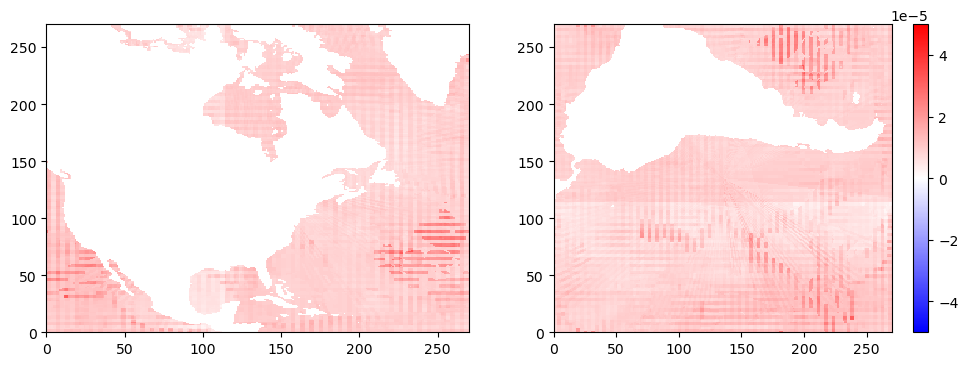

In [62]:
# Plot some fields

#vartoplot = (ECCO_DIC.DIC*ECCO_DIC.maskC).isel(time=slice(0,12)).mean('time')
vartoplot = CO2flux_err

vartoplot = np.where(ECCO_SALT.maskC.isel(k=0) == 0, np.nan, vartoplot)
                                                
fieldtoplot = np.nanmean(vartoplot,axis=0)
#fieldtoplot = ECCO_DIC.DIC.isel(time=slice(0,12)).mean(('time','k'))
tiles = [10,11]
clims = [-5e-5,5e-5]

landmask = ECCO_THETA.maskC.isel(k=0)
fieldtoplot = np.where(landmask, fieldtoplot, np.nan)

fig, axs = plt.subplots(1, 2, figsize = (12,4))

axs[0].pcolormesh(np.rot90(fieldtoplot[tiles[0],:,:]),clim=clims,cmap='bwr')
#fig.colorbar(axs[0].collections[0], ax=axs[0])
axs[1].pcolormesh(fieldtoplot[tiles[1],:,:],clim=clims,cmap='bwr')
fig.colorbar(axs[1].collections[0], ax=axs[1])


C:\Users\nm455\Anaconda3\envs\MTM\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


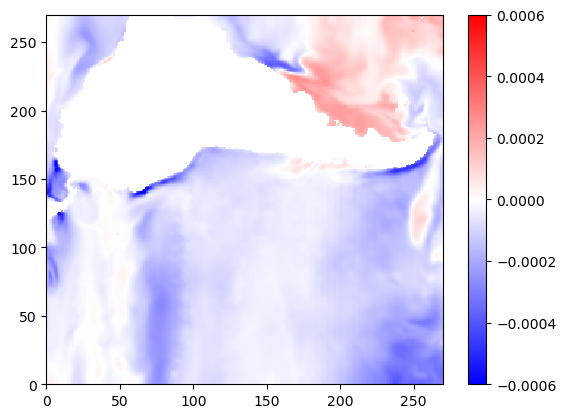

In [53]:
plt.pcolormesh((ECCO_Cflux/ECCO_area).isel(time=0,face=11),cmap='bwr')
plt.colorbar()
plt.clim(-0.0006,0.0006)

C:\Users\nm455\Anaconda3\envs\MTM\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


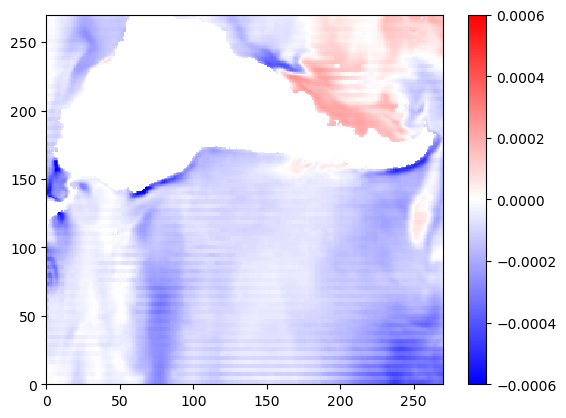

In [54]:
plt.pcolormesh((ECCO_Cflux_lb2/ECCO_area).isel(time=0,face=11),cmap='bwr')
plt.colorbar()
plt.clim(-0.0006,0.0006)

C:\Users\nm455\Anaconda3\envs\MTM\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


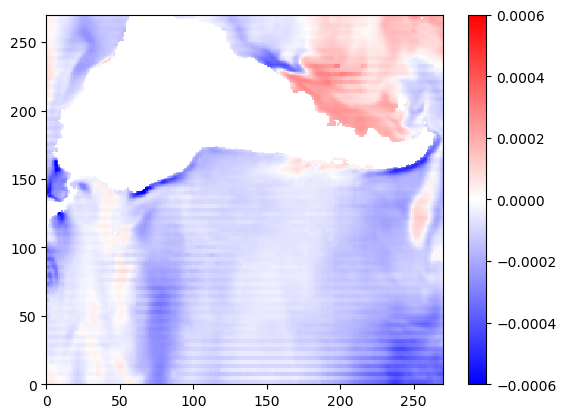

In [56]:
ECCO_Cflux_mod2 = (xr.where(ECCO_CO2flux.fluxCO2>=0,ECCO_CO2flux.fluxCO2 + 2*CO2flux_err,ECCO_CO2flux.fluxCO2 - 2*CO2flux_err))*ECCO_area
plt.pcolormesh((ECCO_Cflux_mod2/ECCO_area).isel(time=0,face=11),cmap='bwr')
plt.colorbar()
plt.clim(-0.0006,0.0006)

In [59]:
CO2flux_err.max()

0.000130676

In [5]:
## Specify tracers

S0=35

ECCO_carbon = ECCO_Cstar.Cstar

## Define grid area, volume and depth, as well as land mask
ECCO_land_mask = ECCO_THETA.maskC

ECCO_area = ECCO_THETA.rA*ECCO_land_mask.isel(k=0)
ECCO_depth = -ECCO_THETA.Z.values

dArea_3D = ECCO_area.expand_dims({'k':ECCO_depth},axis=1).assign_coords(k=ECCO_THETA.k)
dArea_4D = ECCO_area.expand_dims({'k':ECCO_depth},axis=1).assign_coords(k=ECCO_THETA.k).expand_dims({'time':ECCO_THETA.time},axis=0).assign_coords(time=ECCO_THETA.time)
dSArea_3D = dArea_3D.copy(deep=True)

## Define grid area, volume and depth, as well as land mask

#ETANcorr=np.nan_to_num(1+ECCO_ETAN.ETAN/ECCO_ETAN.Depth, neginf = 0, posinf = 0) # Sea surface height correction
ECCO_volume = dArea_3D*ECCO_THETA.hFacC*ECCO_THETA.drF*ECCO_land_mask
#ECCO_volume = (dArea_4D*ECCO_THETA.hFacC*ECCO_THETA.drF*ECCO_land_mask*np.repeat(ETANcorr[:,:,np.newaxis,:,:],50,axis=2)).chunk(chunks=chunks)
vol500 = ECCO_volume.copy(deep=True)
depth_ind = np.argmin(ECCO_depth<2000) # Set 'v500' depth

# Creating 4D mask
#NEMO_mask_4D = NEMO_mask_renamed.expand_dims({'time':NEMO_historical_tracers.time.size},axis=1).assign_coords(time=NEMO_historical_tracers.time)

# Defining 9 basins
#Basins = ECCO_THETA.face.rename(face="Basin")
Basins = ECCO_mask.Basins.values

## Specify T,S
ECCO_T = ECCO_THETA.THETA*(~ECCO_THETA.maskC-1)/(~ECCO_THETA.maskC-1)
ECCO_S = ECCO_SALT.SALT*(~ECCO_SALT.maskC-1)/(~ECCO_SALT.maskC-1)


## Specify fluxes
ECCO_hfds = ECCO_TFLUX.TFLUX*ECCO_area 
ECCO_sfi = ECCO_SFLUX.SFLUX*ECCO_area + (ECCO_oceSPtnd.oceSPtnd*ECCO_area).sum('k')
ECCO_Cflux = ECCO_CO2flux.fluxCO2*ECCO_area
ECCO_Cflux_ub = (ECCO_CO2flux.fluxCO2 + CO2flux_err)*ECCO_area
ECCO_Cflux_lb = (ECCO_CO2flux.fluxCO2 - CO2flux_err)*ECCO_area
ECCO_Cflux_ub2 = (ECCO_CO2flux.fluxCO2 + 2*CO2flux_err)*ECCO_area
ECCO_Cflux_lb2 = (ECCO_CO2flux.fluxCO2 - 2*CO2flux_err)*ECCO_area
ECCO_Cflux_mod = (ECCO_CO2flux.fluxCO2 + np.random.normal(0,CO2flux_err))*ECCO_area
ECCO_Cflux_mod2 = (xr.where(ECCO_CO2flux.fluxCO2>=0,ECCO_CO2flux.fluxCO2 + 2*CO2flux_err,ECCO_CO2flux.fluxCO2 - 2*CO2flux_err))*ECCO_area

ECCO_Cflux_sed = ((ECCO_sedflux.Cstar_flux*ECCO_mask_bottom.seafloor_mask)*ECCO_Cstar.rA).chunk(chunks={'time':1})
ECCO_wfo = ECCO_oceFWflx.oceFWflx*ECCO_area - 1/S0*ECCO_SFLUX.SFLUX*ECCO_area - 1/S0*ECCO_oceSPtnd.oceSPtnd.sum('k')*ECCO_area

## Turn fluxes into 3D files
ECCO_hfds_3D = ECCO_hfds.expand_dims({'k':ECCO_depth},axis=0).assign_coords(k=ECCO_THETA.k) # units: W
ECCO_sfi_3D = ECCO_sfi.expand_dims({'k':ECCO_depth},axis=0).assign_coords(k=ECCO_THETA.k) # units: g/s
ECCO_wfo_3D = ECCO_wfo.expand_dims({'k':ECCO_depth},axis=0).assign_coords(k=ECCO_THETA.k) # units: kg/sse
ECCO_Cflux_3D = ECCO_Cflux.expand_dims({'k':ECCO_depth},axis=0).assign_coords(k=ECCO_THETA.k) # units: mmol-C/s
ECCO_Cflux_3D_ub = ECCO_Cflux_ub.expand_dims({'k':ECCO_depth},axis=0).assign_coords(k=ECCO_THETA.k) # units: mmol-C/s
ECCO_Cflux_3D_lb = ECCO_Cflux_lb.expand_dims({'k':ECCO_depth},axis=0).assign_coords(k=ECCO_THETA.k) # units: mmol-C/s
ECCO_Cflux_3D_ub2 = ECCO_Cflux_ub2.expand_dims({'k':ECCO_depth},axis=0).assign_coords(k=ECCO_THETA.k) # units: mmol-C/s
ECCO_Cflux_3D_lb2 = ECCO_Cflux_ub2.expand_dims({'k':ECCO_depth},axis=0).assign_coords(k=ECCO_THETA.k) # units: mmol-C/s
ECCO_Cflux_3D_mod = ECCO_Cflux_mod.expand_dims({'k':ECCO_depth},axis=0).assign_coords(k=ECCO_THETA.k) # units: mmol-C/s
ECCO_Cflux_3D_mod2 = ECCO_Cflux_mod2.expand_dims({'k':ECCO_depth},axis=0).assign_coords(k=ECCO_THETA.k) # units: mmol-C/s

## Set fluxes, area to be zero in the interior
## We also set our volume array that will be used for binning to be zero below a given depth

ECCO_hfds_3D[1:,:,:,:,:] = 0
ECCO_sfi_3D[1:,:,:,:,:] = 0
ECCO_wfo_3D[1:,:,:,:,:] = 0
ECCO_Cflux_3D[1:,:,:,:,:] = 0
ECCO_Cflux_3D_ub[1:,:,:,:,:] = 0
ECCO_Cflux_3D_lb[1:,:,:,:,:] = 0
ECCO_Cflux_3D_ub2[1:,:,:,:,:] = 0
ECCO_Cflux_3D_lb2[1:,:,:,:,:] = 0
ECCO_Cflux_3D_mod[1:,:,:,:,:] = 0
ECCO_Cflux_3D_mod2[1:,:,:,:,:] = 0
dSArea_3D[:,1:,:,:] = 0
vol500[:,depth_ind:,:,:] = 0
#vol500[:,depth_ind:,:,:,:] = 0

## Remove benthic flux of C*

ECCO_Cflux_3D = ECCO_Cflux_3D - ECCO_Cflux_sed
ECCO_Cflux_3D_ub = ECCO_Cflux_3D_ub - ECCO_Cflux_sed
ECCO_Cflux_3D_lb = ECCO_Cflux_3D_lb - ECCO_Cflux_sed
ECCO_Cflux_3D_ub2 = ECCO_Cflux_3D_ub2 - ECCO_Cflux_sed
ECCO_Cflux_3D_lb2 = ECCO_Cflux_3D_lb2 - ECCO_Cflux_sed
ECCO_Cflux_3D_mod = ECCO_Cflux_3D_mod - ECCO_Cflux_sed
ECCO_Cflux_3D_mod2 = ECCO_Cflux_3D_mod2 - ECCO_Cflux_sed

## Flatten variables of interest into 2D arrays (time x flattened spatial dimensions)

#da.config.set(**{'array.slicing.split_large_chunks': True})

volcello_flattened = (ECCO_volume.stack(z=("face","j", "i", "k")))
vol_500_flattened = vol500.stack(z=("face","j", "i", "k"))
bigthetao_flattened = (ECCO_T.stack(z=("face","j", "i", "k")))
so_flattened = (ECCO_S.stack(z=("face","j", "i", "k")))
carbon_flattened = (ECCO_carbon.stack(z=("face","j", "i", "k")))
areacello_flattened = (dSArea_3D.stack(z=("face","j", "i", "k")))
mask_flattened = (ECCO_mask.mask_ECCO.stack(z=("face","j", "i", "k")))
hfds_flattened = ECCO_hfds_3D.stack(z=("face","j", "i", "k"))
sfi_flattened = ECCO_sfi_3D.stack(z=("face","j", "i", "k"))
wfo_flattened = ECCO_wfo_3D.stack(z=("face","j", "i", "k"))
Cflux_flattened = ECCO_Cflux_3D.stack(z=("face","j", "i", "k"))
Cflux_ub_flattened = ECCO_Cflux_3D_ub.stack(z=("face","j", "i", "k"))
Cflux_lb_flattened = ECCO_Cflux_3D_lb.stack(z=("face","j", "i", "k"))
Cflux_ub2_flattened = ECCO_Cflux_3D_ub2.stack(z=("face","j", "i", "k"))
Cflux_lb2_flattened = ECCO_Cflux_3D_lb2.stack(z=("face","j", "i", "k"))
Cflux_mod_flattened = ECCO_Cflux_3D_mod.stack(z=("face","j", "i", "k"))
Cflux_mod2_flattened = ECCO_Cflux_3D_mod2.stack(z=("face","j", "i", "k"))


## Shorten their names (not necessary but makes for easier code readability)
BA = mask_flattened
V = volcello_flattened
V500 = vol_500_flattened
S = ((so_flattened))
T = ((bigthetao_flattened))
C = carbon_flattened
A = (areacello_flattened)
HF = hfds_flattened
SFI = sfi_flattened
WFO = wfo_flattened
CF = Cflux_flattened
CFu = Cflux_ub_flattened
CFb = Cflux_lb_flattened
CFu2 = Cflux_ub2_flattened
CFb2 = Cflux_lb2_flattened
CFm = Cflux_mod_flattened
CFm2 = Cflux_mod2_flattened

C:\Users\nm455\Anaconda3\envs\MTM\lib\site-packages\xarray\core\variable.py:1722: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  result = result._stack_once(dims, new_dim)
C:\Users\nm455\Anaconda3\envs\MTM\lib\site-packages\xarray\core\variable.py:1722: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set 

Text(0.5, 1.0, 'Total CO2 flux')

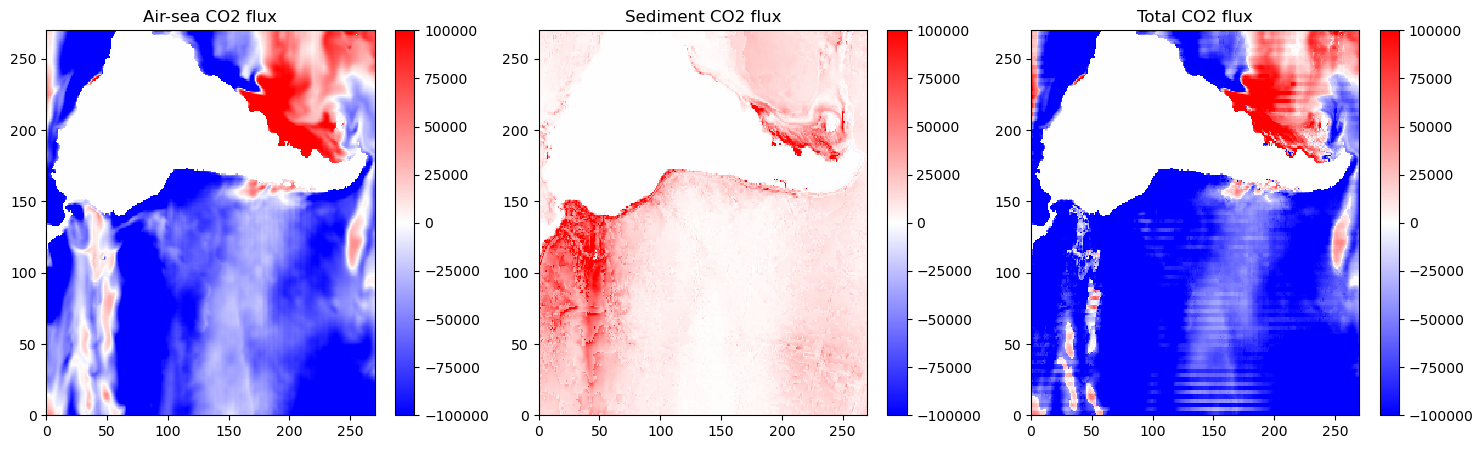

In [22]:
## Plot fluxes to check

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (18,5))
fig.colorbar
cmin=-100000
cmax=100000

time=0
face=11

c=ax1.pcolor(ECCO_Cflux_mod2.isel(time=time, face=face), vmin=cmin, vmax=cmax, cmap='bwr')
fig.colorbar(c, ax=ax1)
ax1.set_title('Air-sea CO2 flux')

c=ax2.pcolor(ECCO_Cflux_sed.isel(time=time, face=face).sum('k'), vmin=cmin, vmax=cmax, cmap='bwr')
fig.colorbar(c, ax=ax2)
ax2.set_title('Sediment CO2 flux')

ax3.pcolor(ECCO_Cflux_3D_mod2.isel(time=time, face=face).sum('k'), vmin=cmin, vmax=cmax, cmap='bwr')
fig.colorbar(c, ax=ax3)
ax3.set_title('Total CO2 flux')


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

C:\Users\nm455\Anaconda3\envs\MTM\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
C:\Users\nm455\AppData\Local\Temp\ipykernel_261692\1483921616.py:113: RuntimeWarning: divide by zero encountered in log10
  BSP.draw(x,y,np.log10(v),vals['bounding_box'],'grey', depth=tree_depth)


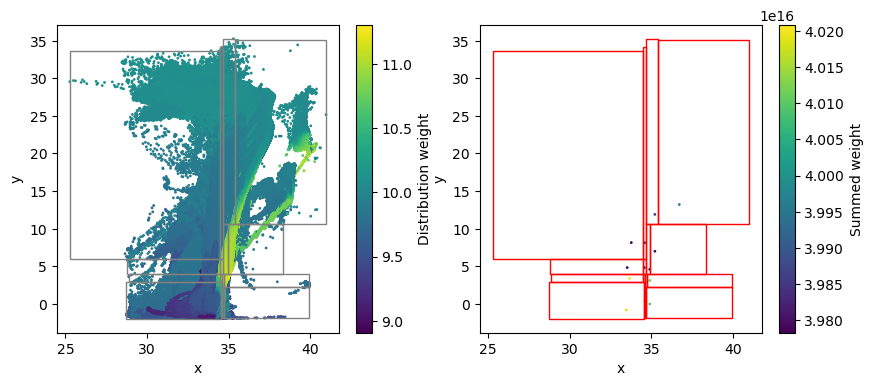

KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

In [23]:
## Define the number of BSP bins to output, where number = 2**tree_depth
tree_depth = 4
nbasins = len(Basins)
# Note: if 2**depth approaches the sample size, the code will not work as an equal volume constraint will become impossible!

## Define the window of time over which BSP bins are calculated - this is important when parallelising this process
window = 1
ti = 0 #int(sys.argv[1])

## Create empty arrays that will be filled by the BSP-ised bins
## Array sizes are (Basin, time, BSP depth) other than for the bin corners which are
## (Basin, time, BSP depth, 4)

partitions_hist = np.zeros((nbasins, window,2**tree_depth, 4))
T_mean_hist = np.zeros((nbasins, window,2**tree_depth))
S_mean_hist = np.zeros((nbasins, window,2**tree_depth))
C_mean_hist = np.zeros((nbasins, window,2**tree_depth))
V_sum_hist = np.zeros((nbasins, window,2**tree_depth))
V500_sum_hist = np.zeros((nbasins, window,2**tree_depth))
A_sum_hist = np.zeros((nbasins, window,2**tree_depth))
hfds_sum_hist = np.zeros((nbasins, window,2**tree_depth))
sfi_sum_hist = np.zeros((nbasins, window,2**tree_depth))
wfo_sum_hist = np.zeros((nbasins, window,2**tree_depth))
Cflux_sum_hist = np.zeros((nbasins, window,2**tree_depth))
Cflux_ub_sum_hist = np.zeros((nbasins, window,2**tree_depth))
Cflux_lb_sum_hist = np.zeros((nbasins, window,2**tree_depth))
Cflux_ub2_sum_hist = np.zeros((nbasins, window,2**tree_depth))
Cflux_lb2_sum_hist = np.zeros((nbasins, window,2**tree_depth))
Cflux_mod_sum_hist = np.zeros((nbasins, window,2**tree_depth))
Cflux_mod2_sum_hist = np.zeros((nbasins, window,2**tree_depth))


## Run a loop over times and basins

'''
1) calc: This function calculates the BSP bins for any 2D distribution. We input the x,y, and v parameters, as well as the 
tree depth, first axis to split orthogonal to, and any diagnostics we want to output. 
We are able to output summed variables for each bin, and meaned variables for each bin.
The weight over which the mean is calculated can also be different to the distribution weight, v.

2) split: The `calc` function outputs a large nested list, which needs to be split into the constituent diagnostics of interest. 
Due to the recursive nature of the `calc` function, this splitting must be accomplished in a second function, `split`.
The output of the `split` function is a dictionary with BSP box boundaries, summed variables and meaned variables. 

3) draw: The `draw` function allows us to visualise the BSP boundaries on top of the original distribution. 
'''

time_array = np.zeros(window)

for i in tqdm(range(ti*window, (ti+1)*window)):
#for i in range(ti*window, (ti+1)*window):
#    time_array[int(i-ti*window)] = i
    for j in tqdm(range(Basins.size)):
#    for j in range(Basins.size):

        # Get a single timestep as numpy, not dask
        ## The x and y axes
        x = S[i,:].values
        y = T[i,:].values
        ## Any tracers to find the weighted mean of
        z = C[i,:].values
        ## The 2D distribution to calculate bins on
        v = V500.values
        #v = V500[i,:].values
        
        ## Summed variables to output for each bin
        c = V.values*BA[j,:].values
        #c = V[i,:].values*BA[j,:].values
        a = A.values*BA[j,:].values
        u = HF[i,:].values*BA[j,:].values
        s = SFI[i,:].values*BA[j,:].values
        q = CF[i,:].values*BA[j,:].values
        w = WFO[i,:].values*BA[j,:].values
        qu = CFu[i,:].values*BA[j,:].values
        ql = CFb[i,:].values*BA[j,:].values
        qu2 = CFu2[i,:].values*BA[j,:].values
        ql2 = CFb2[i,:].values*BA[j,:].values
        qm = CFm[i,:].values*BA[j,:].values
        qm2 = CFm2[i,:].values*BA[j,:].values
                   
        
        # Clean out NAN values
        idx = np.isfinite(y)
        x = x[idx]
        y = y[idx]
        z = z[idx]
        v = v[idx]      
        c = c[idx]
        a = a[idx]
        u = u[idx]
        s = s[idx]
        q = q[idx]
        w = w[idx]
        qu = qu[idx]
        ql = ql[idx]
        qu2 = qu2[idx]
        ql2 = ql2[idx]
        qm = qm[idx]
        qm2 = qm2[idx]


        ## Calculate the BSP bins
        BSP_out = BSP.calc(x,y,v, depth=tree_depth, axis=1, mean=[x,y,z],sum=[v,c,a,u,s,q,w,qu,ql,qu2,ql2,qm,qm2],weight=c)
        # Split the output into constituent diagnostics
        vals = BSP.split(BSP_out, depth=tree_depth)
        
        ## Draw the BSP bins onto original grid
        
        if i == ti*window and j==0:

            fig = plt.figure(figsize=(10,4))
            ax = fig.add_subplot(1,2,1)
            BSP.draw(x,y,np.log10(v),vals['bounding_box'],'grey', depth=tree_depth)
            cbar = plt.colorbar()
            plt.xlabel('x')
            plt.ylabel('y')
            cbar.set_label('Distribution weight')
            
            ax = fig.add_subplot(1,2,2)
            BSP.draw(vals['meaned_vals'][:,0],vals['meaned_vals'][:,1],vals['summed_vals'][:,0],vals['bounding_box'],'red', depth=tree_depth, cmap=plt.cm.viridis)
            cbar = plt.colorbar()
            plt.xlabel('x')
            plt.ylabel('y')
            cbar.set_label('Summed weight')
        
            plt.show()
            plt.savefig('BSP_bins.png', bbox_inches='tight', dpi=300)
            
        ## Allocate the BSP outputs into arrays
            
        partitions_hist[j,int(i-ti*window),:,:] = vals['bounding_box']
        S_mean_hist[j,int(i-ti*window),:] = vals['meaned_vals'][:,0]
        T_mean_hist[j,int(i-ti*window),:] = vals['meaned_vals'][:,1]
        C_mean_hist[j,int(i-ti*window),:] = vals['meaned_vals'][:,2]
        V500_sum_hist[j,int(i-ti*window),:] = vals['summed_vals'][:,0]
        V_sum_hist[j,int(i-ti*window),:] = vals['summed_vals'][:,1]
        A_sum_hist[j,int(i-ti*window),:] = vals['summed_vals'][:,2]
        hfds_sum_hist[j,int(i-ti*window),:] = vals['summed_vals'][:,3]
        sfi_sum_hist[j,int(i-ti*window),:] = vals['summed_vals'][:,4]
        Cflux_sum_hist[j,int(i-ti*window),:] = vals['summed_vals'][:,5]
        wfo_sum_hist[j,int(i-ti*window),:] = vals['summed_vals'][:,6]
        Cflux_ub_sum_hist[j,int(i-ti*window),:] = vals['summed_vals'][:,7]
        Cflux_lb_sum_hist[j,int(i-ti*window),:] = vals['summed_vals'][:,8]
        Cflux_ub2_sum_hist[j,int(i-ti*window),:] = vals['summed_vals'][:,9]
        Cflux_lb2_sum_hist[j,int(i-ti*window),:] = vals['summed_vals'][:,10]
        Cflux_mod_sum_hist[j,int(i-ti*window),:] = vals['summed_vals'][:,11]
        Cflux_mod2_sum_hist[j,int(i-ti*window),:] = vals['summed_vals'][:,12]
        


In [24]:
## We redefine each outputted numpy array as an xarray DataArray with the goal of saving it as a netCDF file

da_partitions_hist = xr.DataArray(data = partitions_hist, dims = ["Basin","Time", "Depth", "Coords"], 
                           coords=dict(Basin = Basins, Time = time_array, Depth= np.arange(2**tree_depth), Coords = np.arange(4)),
                        attrs=dict(description="[x0,y0,xmax,ymax] bounds of BSP framework", variable_id="Partitions"))
da_S_mean_hist = xr.DataArray(data = S_mean_hist, dims = ["Basin", "Time", "Depth"], 
                           coords=dict(Basin = Basins, Time = time_array, Depth=np.arange(2**tree_depth)),
                        attrs=dict(description="Mean Salinity", units="g/kg", variable_id="S"))
da_T_mean_hist = xr.DataArray(data = T_mean_hist, dims = ["Basin", "Time","Depth"], 
                           coords=dict(Basin = Basins, Time = time_array, Depth=np.arange(2**tree_depth)),
                        attrs=dict(description="Mean Temperature", units="K", variable_id="T"))
da_C_mean_hist = xr.DataArray(data = C_mean_hist, dims = ["Basin", "Time","Depth"], 
                           coords=dict(Basin = Basins, Time = time_array, Depth=np.arange(2**tree_depth)),
                        attrs=dict(description="Mean C_star", units="mmol-C/m3", variable_id="C_star"))
da_V_sum_hist = xr.DataArray(data = V_sum_hist, dims = ["Basin", "Time","Depth"], 
                           coords=dict(Basin = Basins, Time = time_array, Depth=np.arange(2**tree_depth)),
                        attrs=dict(description="Total Volume", units="m^3", variable_id="Basin V_sum"))
da_A_sum_hist = xr.DataArray(data = A_sum_hist, dims = ["Basin", "Time","Depth"],
                           coords=dict(Basin = Basins, Time = time_array, Depth=np.arange(2**tree_depth)),
                        attrs=dict(description="Total Area", units="m^2", variable_id="Basin A_sum"))
da_hfds_sum_hist = xr.DataArray(data = hfds_sum_hist, dims = ["Basin", "Time","Depth"], 
                           coords=dict(Basin = Basins, Time = time_array, Depth=np.arange(2**tree_depth)),
                        attrs=dict(description="Heat Flux", units="W", variable_id="hfds"))
da_sfi_sum_hist = xr.DataArray(data = sfi_sum_hist, dims = ["Basin", "Time","Depth"], 
                           coords=dict(Basin = Basins, Time = time_array, Depth=np.arange(2**tree_depth)),
                        attrs=dict(description="Salt Flux", units="g/s", variable_id="sfi"))
da_Cflux_sum_hist = xr.DataArray(data = Cflux_sum_hist, dims = ["Basin", "Time","Depth"],
                           coords=dict(Basin = Basins, Time = time_array, Depth=np.arange(2**tree_depth)),
                        attrs=dict(description="Carbon Flux", units="mmol-C/s", variable_id="Cflux"))
da_wfo_sum_hist = xr.DataArray(data = wfo_sum_hist, dims = ["Basin", "Time","Depth"], 
                           coords=dict(Basin = Basins, Time = time_array, Depth=np.arange(2**tree_depth)),
                        attrs=dict(description="Freshwater Flux", units="kg/s", variable_id="wfo"))
da_Cflux_ub_sum_hist = xr.DataArray(data = Cflux_ub_sum_hist, dims = ["Basin", "Time","Depth"],
                           coords=dict(Basin = Basins, Time = time_array, Depth=np.arange(2**tree_depth)),
                        attrs=dict(description="Carbon Flux upper bound 1", units="mmol-C/s", variable_id="Cflux ub1"))
da_Cflux_lb_sum_hist = xr.DataArray(data = Cflux_lb_sum_hist, dims = ["Basin", "Time","Depth"],
                           coords=dict(Basin = Basins, Time = time_array, Depth=np.arange(2**tree_depth)),
                        attrs=dict(description="Carbon Flux lower bound 1", units="mmol-C/s", variable_id="Cflux lb1"))
da_Cflux_ub2_sum_hist = xr.DataArray(data = Cflux_ub2_sum_hist, dims = ["Basin", "Time","Depth"],
                           coords=dict(Basin = Basins, Time = time_array, Depth=np.arange(2**tree_depth)),
                        attrs=dict(description="Carbon Flux upper bound 2", units="mmol-C/s", variable_id="Cflux ub2"))
da_Cflux_lb2_sum_hist = xr.DataArray(data = Cflux_lb2_sum_hist, dims = ["Basin", "Time","Depth"],
                           coords=dict(Basin = Basins, Time = time_array, Depth=np.arange(2**tree_depth)),
                        attrs=dict(description="Carbon Flux lower bound 2", units="mmol-C/s", variable_id="Cflux lb2"))
da_Cflux_mod_sum_hist = xr.DataArray(data = Cflux_mod_sum_hist, dims = ["Basin", "Time","Depth"],
                           coords=dict(Basin = Basins, Time = time_array, Depth=np.arange(2**tree_depth)),
                        attrs=dict(description="Carbon Flux with random error", units="mmol-C/s", variable_id="Cflux mod"))
da_Cflux_mod2_sum_hist = xr.DataArray(data = Cflux_mod2_sum_hist, dims = ["Basin", "Time","Depth"],
                           coords=dict(Basin = Basins, Time = time_array, Depth=np.arange(2**tree_depth)),
                        attrs=dict(description="Carbon Flux enhanced by error", units="mmol-C/s", variable_id="Cflux mod2"))

## Input all xarray DataArrays into a DataSet

ds_BSP = xr.Dataset()
ds_BSP['Partitions_hist'] = da_partitions_hist
ds_BSP['T_mean_hist'] = da_T_mean_hist
ds_BSP['S_mean_hist'] = da_S_mean_hist
ds_BSP['C_mean_hist'] = da_C_mean_hist
ds_BSP['V_sum_hist'] = da_V_sum_hist
ds_BSP['A_sum_hist'] = da_A_sum_hist
ds_BSP['hfds_sum_hist'] = da_hfds_sum_hist
ds_BSP['sfi_sum_hist'] = da_sfi_sum_hist
ds_BSP['Cflux_sum_hist'] = da_Cflux_sum_hist
ds_BSP['wfo_sum_hist'] = da_wfo_sum_hist
ds_BSP['Cflux_ub_sum_hist'] = da_Cflux_ub_sum_hist
ds_BSP['Cflux_lb_sum_hist'] = da_Cflux_lb_sum_hist
ds_BSP['Cflux_ub2_sum_hist'] = da_Cflux_ub2_sum_hist
ds_BSP['Cflux_lb2_sum_hist'] = da_Cflux_lb2_sum_hist
ds_BSP['Cflux_mod_sum_hist'] = da_Cflux_mod_sum_hist
ds_BSP['Cflux_mod2_sum_hist'] = da_Cflux_mod2_sum_hist

ds_BSP.to_netcdf(mylist[8]+'BSP_ECCO_monthly_%i_%i.nc' %(ti*window, (ti+1)*window-1))